# Import packages
The package version information of the environment is in the README file.

In [1]:
#Basic
import numpy as np
import pandas as pd
import pickle
import copy

#Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Torch
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

#SKlearn
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

#SHAP
import shap     
shap.initjs()

#Explanation evaluation
import eli5
from eli5.permutation_importance import get_score_importances
import xgboost as xgb
from scipy import stats


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


# Data processing
The data are divided based on the pre-prepared index group. The code of the data division is not listed.

In [2]:
#Read the raw data and select the X and Y features
housing_modified = pd.read_csv("/newdisk/housing_price_data.csv")
x_data = housing_modified[['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PRTATIO','LSTAT']]
y_data = housing_modified[['PRICE']]
x_column_names = x_data.columns
y_column_names = y_data.columns  

#Divide the data (input X and output Y) into train, validation, and test sets based on the pre-prepared sample indexes
with open('/newdisk/data_split.pickle', 'rb') as f:
    indexs = pickle.load(f)
y_train_index, y_val_index, y_test_index = indexs

x_train= housing_modified.iloc[y_train_index][x_column_names]
x_val= housing_modified.iloc[y_val_index][x_column_names]
x_test= housing_modified.iloc[y_test_index][x_column_names]

y_train= housing_modified.iloc[y_train_index][y_column_names]
y_val= housing_modified.iloc[y_val_index][y_column_names]
y_test= housing_modified.iloc[y_test_index][y_column_names]

In [3]:
# Data standardization based on the train data

# Input X
scaler_x = StandardScaler()
scaler_x.fit(x_train)

x_train_std = pd.DataFrame(scaler_x.transform(x_train), columns=x_column_names)
x_val_std = pd.DataFrame(scaler_x.transform(x_val), columns=x_column_names)
x_test_std = pd.DataFrame(scaler_x.transform(x_test), columns=x_column_names)

# Output Y
scaler_y = StandardScaler()
scaler_y.fit(y_train)

y_train_std = pd.DataFrame(scaler_y.transform(y_train), columns=y_column_names)
y_val_std = pd.DataFrame(scaler_y.transform(y_val), columns=y_column_names)
y_test_std = pd.DataFrame(scaler_y.transform(y_test), columns=y_column_names)

# Data reverse
x_train_mean = x_train.mean()
x_train_STD = x_train.std()
y_train_mean = y_train.mean()
y_train_STD = y_train.std()

x_train_inv = scaler_x.inverse_transform(x_train_std)
y_train_inv = scaler_y.inverse_transform(y_train_std)
x_test_inv = scaler_x.inverse_transform(x_test_std)
y_test_inv = scaler_y.inverse_transform(y_test_std)

# Model structure and uncertainty explanation
The code for model training for housing price prediction is not provided. The uncertainty explanation is implemented based on the pre-trained model parameters (trained_model.pth).

In [4]:
#Neural network structure 
class FullyConnectedNuralNetwork(nn.Module):
    def __init__(self):
        super(FullyConnectedNuralNetwork,self).__init__()
        self.hidden1=nn.Sequential(
                nn.Linear(in_features=12,out_features= 100,bias=True),
                nn.ReLU())
        self.hidden2=nn.Sequential(
                nn.Linear(in_features=100,out_features=50,bias=True),
                nn.ReLU())
        self.predict=nn.Sequential(
                nn.Dropout(p=0.1),
                nn.Linear(in_features= 50,out_features=1,bias=True))
                
    def forward(self,x):
        x=self.hidden1(x)
        x=self.hidden2(x)
        x=self.predict(x)
        return x

In [5]:
# Datasets and dataloaders for Torch
train_data= TensorDataset(torch.from_numpy(x_train_std.to_numpy().astype(np.float32)), torch.from_numpy(y_train_std.to_numpy().astype(np.float32)))
validation_data= TensorDataset(torch.from_numpy(x_val_std.to_numpy().astype(np.float32)), torch.from_numpy(y_val_std.to_numpy().astype(np.float32)))
test_data= TensorDataset(torch.from_numpy(x_test_std.to_numpy().astype(np.float32)), torch.from_numpy(y_test_std.to_numpy().astype(np.float32)))

train_loader= DataLoader(dataset=train_data,batch_size=64,shuffle=True, num_workers=2)
validation_loader= DataLoader(dataset=validation_data,batch_size=64,shuffle=True, num_workers=2)
test_loader= DataLoader(dataset=test_data,batch_size=64,shuffle=False, num_workers=2)

In [6]:
# Function to estimate the uncertainty of the designed deep learning model

def DP_va(c): #input c should be Dataframe format 
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    testnet = FullyConnectedNuralNetwork().to(device)
    testnet.load_state_dict(torch.load("/newdisk/trained_model.pth"))
    testnet.train()

    #MC-dropout for 100 times output d
    d_update= []
    c= torch.from_numpy(c).to(device)     
    for i in range(100):
        d= testnet(c)
        d= d.cpu()
        d= d.detach().numpy()
        d= scaler_y.inverse_transform(d)
        d_update.append(d)

    d_update_array= np.array(d_update)
    new_d= np.squeeze(np.array(d_update_array))

    if len(new_d.shape) ==2: 
       d_add_colum= new_d.shape[1]

    else:
       new_d= new_d[:, np.newaxis]
       d_add_colum= new_d.shape[1]

    #Variance calculation
    d_final= []
    for j in range(d_add_colum):
        colum_var = np.var(new_d[:, j])
        d_final.append(colum_var)
    
    d= np.array(d_final)
    d= d[:, np.newaxis] #add one y axis demension 
    return d

The uncertainty explanation process takes about 1 hour in the authors' workstation. To save time, we also provide an example of the uncertainty explanation result (global_xai_variance_[0.71805476].pickle).

In [ ]:
#Use SHAP to explain the uncertainty (i.e., the function DP_va())
#X is DataFrame format, x_train_std are the background data, shap_values is List format
explainer= shap.KernelExplainer(DP_va, x_train_std.to_numpy().astype(np.float32)) 
shap_values = explainer.shap_values(x_test_std.to_numpy().astype(np.float32))

#expected_value is important to be used in the local explanation visualization
expected_value = explainer.expected_value
print(expected_value)

#Save the uncertainty explanation results 
with open("/newdisk/gloabl_xai_variance_"+str(expected_value)+".pickle", "wb") as f:
    pickle.dump(shap_values, f)

# Global and local uncertainty explanation results


In [7]:
#Load the provided example of uncertainty explanation results
with open("/newdisk/gloabl_xai_variance_[0.71805476].pickle", "rb") as f:
    shap_values = pickle.load(f)
    expected_value=0.71805476

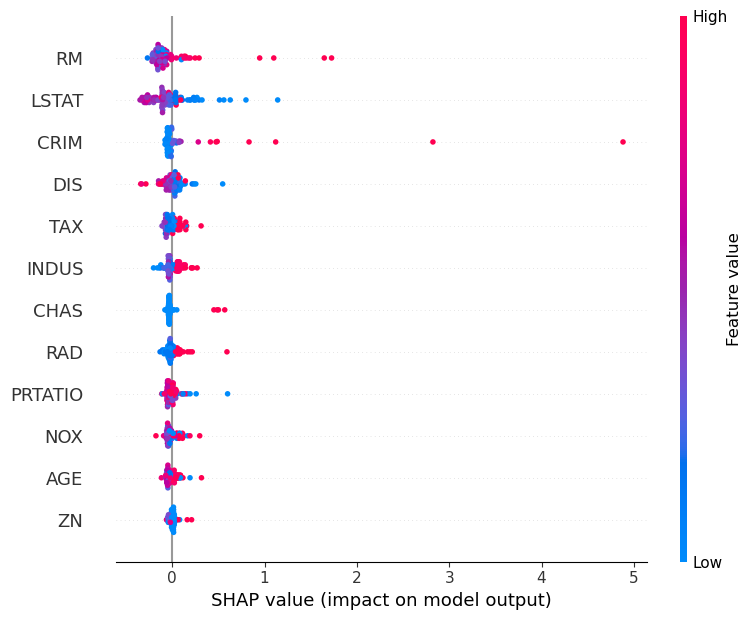

<Figure size 700x600 with 0 Axes>

In [8]:
#Global explanation #1 style
shap.summary_plot(shap_values[0], x_test_std, show= False)

plt.figure(figsize=(7, 6))
plt.tight_layout()
plt.show()
plt.close()

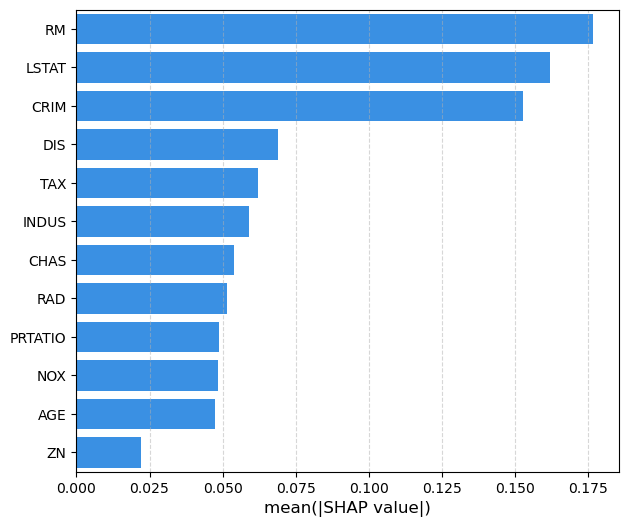

In [9]:
#Global explanation #2 style
feature_names = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PRTATIO','LSTAT']
shap_values_global = np.mean(np.absolute(shap_values[0]),axis=0)

df = pd.DataFrame({"Feature": feature_names, "SHAP Value": shap_values_global})
df = df.sort_values(by="SHAP Value", ascending=False)

plt.figure(figsize=(7, 6))
sns.barplot(x="SHAP Value", y="Feature", data=df, color="dodgerblue")

plt.xlabel("mean(|SHAP value|)", fontsize=12)
plt.ylabel("")
plt.xticks(fontsize=10)
plt.grid(axis="x", linestyle="--", alpha=0.5)

plt.show()
plt.close()

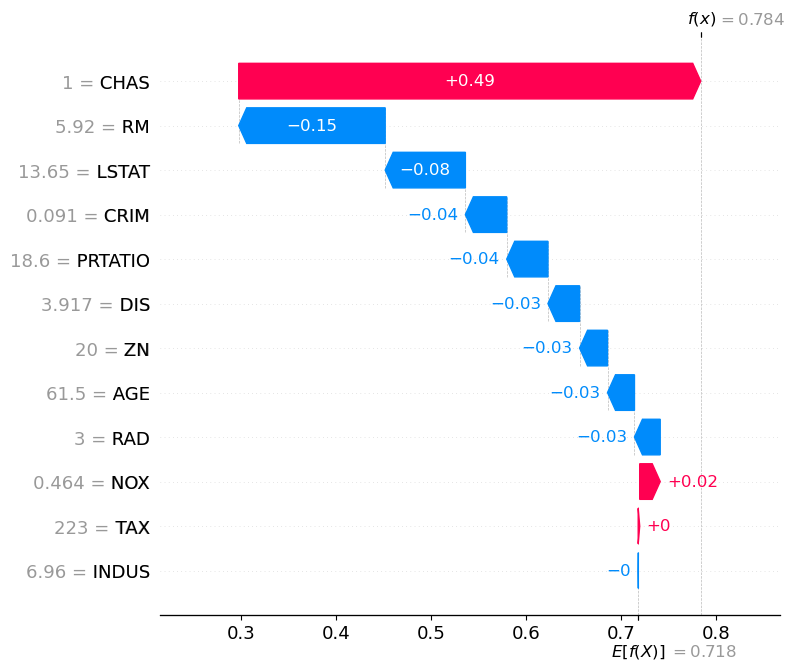

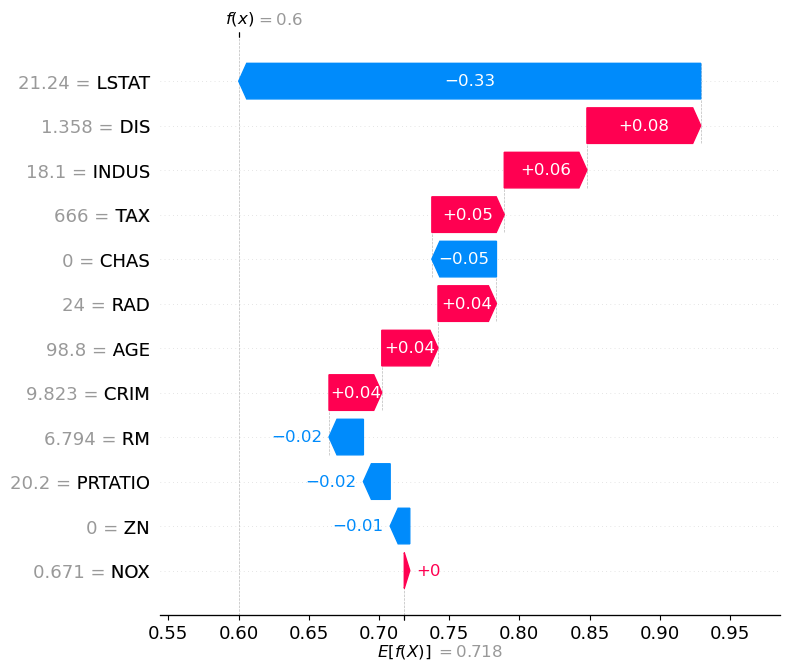

In [10]:
#Local explanation

#Two examples
selected_index=[2,42]

for i in range(len(selected_index)):
    #Convert shap_values to shap.Explanation object
    #Need the expected_value
    shap_explanation = shap.Explanation(values=shap_values[0][selected_index[i]], 
                                        base_values=expected_value, 
                                        data=pd.Series(x_test_inv[selected_index[i]], index=x_column_names))

    shap.plots.waterfall(shap_explanation, max_display=len(x_column_names),show= False)

    plt.show()
    plt.close()

# Explanation comparison and evaluation
Use three XAI methods (i.e., SHAP, PFI, GSM/XGBoost) to compare the global uncertainty explanation results.

In [11]:
#Get the uncertainty estimation results (as "true" values) of train, validation, and test data.
#Due to the randomness of MC-dropout, the results of each experiment can be different.
variances_test=DP_va(x_test_std.to_numpy().astype(np.float32))
variances_train=DP_va(x_train_std.to_numpy().astype(np.float32))
variances_val=DP_va(x_val_std.to_numpy().astype(np.float32))

CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272204863/work/c10/cuda/CUDAFunctions.cpp:112.)


In [12]:
#Global explanation by SHAP
shap_result = np.mean(np.abs(shap_values[0]),axis=0)
print(shap_result)

[0.15262681 0.02213294 0.05904649 0.05383526 0.04849907 0.17656298
 0.04754396 0.06907219 0.05139295 0.06209599 0.04861015 0.16196378]


In [13]:
#Global explanation by PFI
#X are the input samples, y are the "true" values of estimated uncertainty
def score(X, y):
    y_pred = DP_va(X)
    tmp=metrics.mean_squared_error(y,y_pred)
    return tmp

base_score, score_decreases = get_score_importances(score, x_test_std.to_numpy().astype(np.float32), variances_test)
pfi_result = np.mean(np.abs(score_decreases), axis=0)

print(pfi_result)

[0.81383782 0.01258473 0.03009698 0.0271886  0.02631689 0.29168925
 0.02749866 0.05714278 0.07161903 0.03858521 0.01979309 0.21157871]


In [14]:
#Use XGBoost to implement GSM method
#Global explanation by XGB
#Train a XGB model with test samples as X, and "true" values of estimated unceratinty as y
model_xgb=xgb.XGBRegressor()
model_xgb.fit(x_test_std.to_numpy().astype(np.float32),variances_test)
importance=model_xgb.get_booster().get_score()
xgb_result=np.array(list(importance.values()))

print(xgb_result)

[256.  15.  34.  24.  53. 150.  77.  99.   8.  19.  20. 113.]


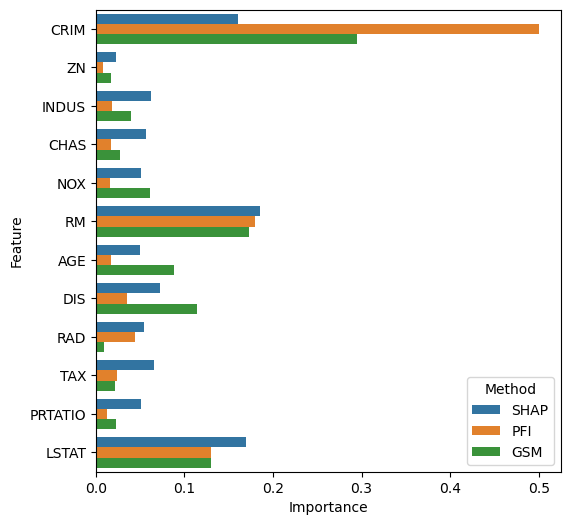

In [15]:
#Comparison of uncertainty explanation by three XAI methods (SHAP, PFI, GSM/XGB)

#Normalization
shap_result=shap_result/np.sum(shap_result)
pfi_result=pfi_result/np.sum(pfi_result)
xgb_result=xgb_result/np.sum(xgb_result)


feature_names = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PRTATIO','LSTAT']
plt.figure(figsize=(6, 6))

df_shap = pd.DataFrame({"Feature": feature_names, "Importance": shap_result, "Method":"SHAP"})
df_pfi = pd.DataFrame({"Feature": feature_names, "Importance": pfi_result, "Method":"PFI"})
df_xgb = pd.DataFrame({"Feature": feature_names, "Importance": xgb_result, "Method":"GSM"})

frames = [df_shap, df_pfi, df_xgb]
result = pd.concat(frames)
sns.barplot(x="Importance", y="Feature", data=result,hue="Method")

plt.show()
plt.close()

In [16]:
#XAI evaluation, use the FC (Faithfulness Correlation) index
runs=100
shap=[]
pfi=[]
xgb=[]

#Prepare the data
traindata=x_train_std.to_numpy().astype(np.float32)
origin_input=x_test_std.to_numpy().astype(np.float32)
origin_output=DP_va(origin_input)

#100 times run
for t in range(runs):    
    replace=np.array(np.median(origin_input,axis=0))
    differencelist=[]
    
    #Each time replace 1 feature
    for i in range(len(replace)):
        tmp_input=copy.deepcopy(origin_input)
        tmp_input[:, i] = replace[i]
        new_output=DP_va(tmp_input)
        difference=np.mean(origin_output-new_output)
        differencelist.append(difference)

    #Spearman correlation
    res_shap=stats.spearmanr(np.array(differencelist),shap_result)
    res_pfi=stats.spearmanr(np.array(differencelist),pfi_result)
    res_xgb=stats.spearmanr(np.array(differencelist),xgb_result)
    
    shap.append(res_shap.correlation)
    pfi.append(res_pfi.correlation)
    xgb.append(res_xgb.correlation)

#Average FC results of three methods
print(np.mean(np.array(shap)),np.std(np.array(shap)))
print(np.mean(np.array(pfi)),np.std(np.array(pfi)))
print(np.mean(np.array(xgb)),np.std(np.array(xgb)))

0.5427972027972028 0.050152878902057156
0.4797902097902099 0.050144248864311194
0.5237062937062937 0.05413956025807875
